In [1]:
from qiskit_aer import AerSimulator, Aer
from qiskit import QuantumCircuit, transpile
from qiskit.circuit.library import MCMT
import time
import hashlib
from math import sqrt, pi
from qiskit.quantum_info import Statevector, Operator, DensityMatrix
from qiskit.circuit import (
    Parameter, QuantumCircuit, ClassicalRegister, QuantumRegister
)
from qiskit.primitives import BackendSampler, StatevectorSampler, Sampler
from qiskit.circuit.library import PhaseGate, QFT
import math
import numpy as np
from random import randint
from qiskit.visualization import plot_histogram

In [2]:
def generate_U(m,thetas):
  U = QuantumCircuit(m, name="U")  # create circuit for our unitary
  U_matrix = np.identity(2**m, dtype=complex) # start out as identity matrix
  for i in range(len(thetas)):
    U_matrix[i, i] = np.exp(2 * np.pi * 1j * thetas[i])
  U.unitary(Operator(U_matrix), range(m))  # apply this unitary gate to first m qubits
  return U.to_gate()

def U_repeated(m,thetas,k):
  # creates a controlled gate that repeats U (k-many times) based on qubit 0
  U_pow = QuantumCircuit(m, name="$U^" + str(k) + "$")
  U_pow.append(generate_U(m,thetas), range(m))
  U_pow.repeat(k)
  U_pow = U_pow.control(1)
  return U_pow

def phase_oracle(m, thetas, n):
  # n is the number of control qubits and m is the qubits of the eigenvector
  po = QuantumCircuit(m+n, name="Phase Oracle")
  U_gate = generate_U(m, thetas)
  for k in range(n):
        U_k_gate = U_gate.power(2**k)
        po.append(U_k_gate.control(), [m + k] + list(range(m)))
  return po

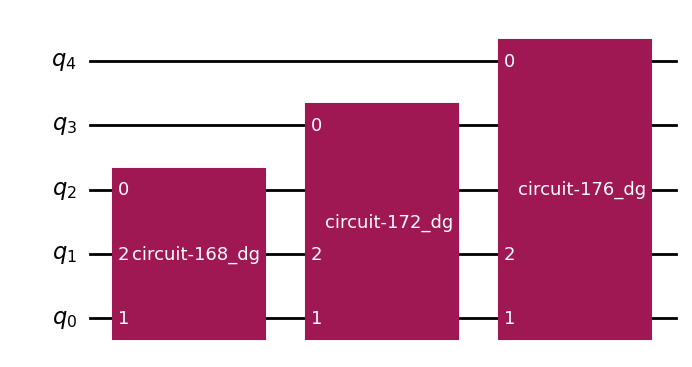

In [3]:
phase_oracle(2, [1,1], 3).decompose().draw(output='mpl', reverse_bits=True)

In [4]:
def get_metric(counts, metric, granularity):
  # counts is a dictionary in the form {value : num_counts}
  # return the value corresponding to the metric
  if metric == "mode":
    return max(counts, key=counts.get)
  elif metric == "mean":
    total_counts = sum(counts.values())
    mean = sum(value * count for value, count in counts.items()) / total_counts
    return mean
  elif metric == "2d_avg":
    total_measurements = sum(counts.values())
    avg_x = 0
    avg_y = 0

    # max_angle = (2**granularity - 1) / (2**granularity) * 2 * math.pi

    for j, count in counts.items():
        theta = (j / (2**granularity)) * 2 * np.pi

        x = np.cos(theta)
        y = np.sin(theta)

        weighted_x = x * count / total_measurements
        weighted_y = y * count / total_measurements

        avg_x += weighted_x
        avg_y += weighted_y

    avg_theta = math.atan2(avg_y, avg_x)
    if avg_theta < 0:
        avg_theta += 2 * np.pi

    return avg_theta * granularity
  else:
    # TODO optional: implement a metric of your own here
    print("invalid metric provided!")
    return -1

In [5]:
def phase_estimation(granularity, thetas, metric="mode", num_shots=500, draw_diagram=False):
  # granularity is the "n", or number of qubits j is stored on
  qreg_j = QuantumRegister(granularity, "q_j")
  qreg_eigenvector = QuantumRegister(1, "q_eigen")
  creg_j = ClassicalRegister(granularity, "c_j")

  measured_thetas = []  # contains data in the form (expected, measured) for each eigenvector
  for eigenvector in range(2):  # for each of our eigenvectors |0> and |1>
    qc = QuantumCircuit(qreg_eigenvector, qreg_j, creg_j)

    # TODO: initialize eigenvector
    if eigenvector == 1:
      qc.x(qreg_eigenvector[0])

    # TODO: build phase estimation circuit
    qc.h(qreg_j)
    phase_oracle_gate = phase_oracle(1, thetas, granularity)
    qc.append(phase_oracle_gate, qreg_eigenvector[:] + qreg_j[:])
    qc.append(QFT(granularity, inverse=True), qreg_j[:])
    qc.measure(qreg_j, creg_j)

    sampler = StatevectorSampler() #Don't extend circuit down to eigenvector
    job = sampler.run([qc,], shots=num_shots)
    counts = job.result()[0].data.c_j.get_int_counts()
    measured_j = get_metric(counts, metric, granularity)
    # print(counts, measured_j)
    measured_theta = measured_j / 2**granularity
    measured_thetas.append(measured_theta)
  # print(measured_thetas)
  circuit_diagram = qc.draw(output='mpl', reverse_bits=True)
  return circuit_diagram if draw_diagram else measured_thetas

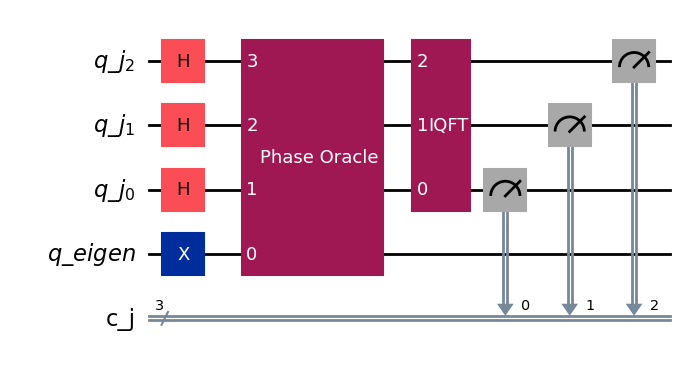

In [6]:
phase_estimation(granularity = 3, thetas=[1,1], draw_diagram=True, metric="2d_avg")

In [7]:
phase_estimation(granularity=5, thetas=[0.7, 0.99], metric="2d_avg")

[0.6850044133319269, 0.9761114251633554]

In [8]:
def initialize_qubits(qc, n, m):
    qc.h(range(n)) # apply hadamard gates
    qc.x(n+m-1) # set qubit to 1

def apply_iqft(qc, measurement_qubits):
    qc.append(QFT(len(measurement_qubits), inverse=True),
                         measurement_qubits)

def measure(qc, n):
    qc.measure(n, n)

In [52]:
from qiskit import QuantumCircuit

def majority_gate(qc, a, b, c):
    qc.ccx(a, b, c)
    qc.cx(a, b)
    qc.cx(b, c)

def unmaj_gate(qc, a, b, c):
    qc.cx(b, c)
    qc.cx(a, b)
    qc.ccx(a, b, c)

def ripple_carry_adder(qc, a, b, cin, cout):
    # a and b are lists of qubit indices for the two numbers
    # cin is the input carry, cout is the output carry
    n = len(a)
    majority_gate(qc, cin, b[0], a[0])
    for i in range(n - 1):
        majority_gate(qc, a[i], b[i + 1], a[i + 1])
    qc.cx(a[n - 1], cout)
    for i in reversed(range(n - 1)):
        unmaj_gate(qc, a[i], b[i + 1], a[i + 1])
    unmaj_gate(qc, cin, b[0], a[0])


from qiskit.circuit.library import MCMT

def quantum_comparator(qc, a, n, flag):
    # Ensure that the qubit list 'a' has enough qubits to represent the number 'n'
    n_binary = format(n, '0' + str(len(a)) + 'b')
    for i, bit in enumerate(reversed(n_binary)):
        if bit == '1':
            qc.x(a[i])
    qc.append(MCMT('x', len(a), 1), a + [flag])  # Multi-controlled X gate
    for i, bit in enumerate(reversed(n_binary)):
        if bit == '1':
            qc.x(a[i])



def controlled_subtraction(qc, a, n, control):
    # Subtract n from a if control qubit is set
    # This is a simplified example; a full implementation would be more complex
    for i, bit in enumerate(format(n, '0' + str(len(a)) + 'b')):
        if bit == '1':
            qc.cx(control, a[i])





def controlled_shift(qc, qubits, control):
    """Controlled shift operation."""
    for i in reversed(range(1, len(qubits))):
        qc.cswap(control, qubits[i], qubits[i - 1])




In [89]:
def controlled_adder_modN(qc, a, N, control):
    """Controlled addition modulo N."""
    # Perform controlled addition using the ripple_carry_adder function
    # Ensure that the control qubit is not included in the 'a' qubits
    ripple_carry_adder(qc, a, [control] * len(a), control, a[-1])  # Reusing the last qubit of 'a' as the output carry

    # Compare and subtract if necessary (modular reduction)
    quantum_comparator(qc, a, N, control)  # Using the control qubit as the flag qubit for comparison
    controlled_subtraction(qc, a, N, control)
    # Reset the flag qubit (control qubit)
    quantum_comparator(qc, a, N, control)

def controlled_mod_mult(qc, a, N, num_qubits, control):
    """Controlled modular multiplication."""
    # Ensure that multiplication_qubits starts from control + 1 and does not exceed the total qubits
    multiplication_qubits = list(range(control + 1, min(control + num_qubits, qc.num_qubits)))
    for i in range(len(multiplication_qubits)):
        if (a >> i) & 1:
            # Ensure that the controlled addition is applied only to the multiplication qubits
            controlled_adder_modN(qc, multiplication_qubits, N, control)
        # Ensure that the controlled shift is applied only to the multiplication qubits
        controlled_shift(qc, multiplication_qubits, control)





def a_x_modN(a, x, N, num_qubits):
    """Performs modular exponentiation a^x mod N."""
    qc = QuantumCircuit(num_qubits)
    control_qubit = num_qubits - 1  # Assuming the last qubit is the control qubit
    # Implement the modular exponentiation circuit for a^x mod N
    for i in range(len(x)):
        if x[i] == '1':
            controlled_mod_mult(qc, a, N, num_qubits, control_qubit)
        # Square for the next bit (handled by the controlled modular multiplication within the circuit)
    return qc


# The rest of the code remains the same


def modular_exponentiation(qc, n, m, a, N):
    num_qubits = m + 1
    for x in range(n):
        exponent = format(2**x, '0' + str(m) + 'b')  # Convert the exponent to binary
        control_qubit = n + m  # Assuming the last qubit is the control qubit
        other_qubits = list(range(n, n + m))

        # Create the a_x_modN circuit and compose it with the main circuit
        a_x_modN_circuit = a_x_modN(a, exponent, N, num_qubits)
        qc.compose(a_x_modN_circuit, qubits=[control_qubit] + other_qubits, inplace=True)


def period_finder(n, m, a, N):
    total_qubits = n + m + 1  # Additional qubits may be needed for the modular addition and comparison
    qc = QuantumCircuit(total_qubits, n)

    # Initialize the qubits
    initialize_qubits(qc, n, m)
    qc.barrier()

    # Apply modular exponentiation
    modular_exponentiation(qc, n, m, a, N)
    qc.barrier()

    # Apply inverse QFT and measure
    apply_iqft(qc, range(n))
    qc.barrier()
    # Measure only the first n qubits
    qc.measure(range(n), range(n))

    return qc


from math import gcd
import random

# Usage example for N = 21
n = 4; m = 4; N = 15

def choose_a(N):
    while True:
        a = random.randint(2, N - 1)
        if gcd(a, N) == 1:
            return a
        else:
            print(f"Found a factor {gcd(a, N)} of {N} by chance!")
            return None

a = choose_a(N)

if a is None:
    print("A non-trivial factor of N was found. No need to proceed with period finding.")
else:
    print(f"Chosen a = {a}")
    qc = period_finder(n, m, a, N)
    # Proceed with the rest of the algorithm)

Found a factor 3 of 15 by chance!
A non-trivial factor of N was found. No need to proceed with period finding.


Counts:
 {'0000': 10000}
Measurements: [0]
Probabilities: [1.0]


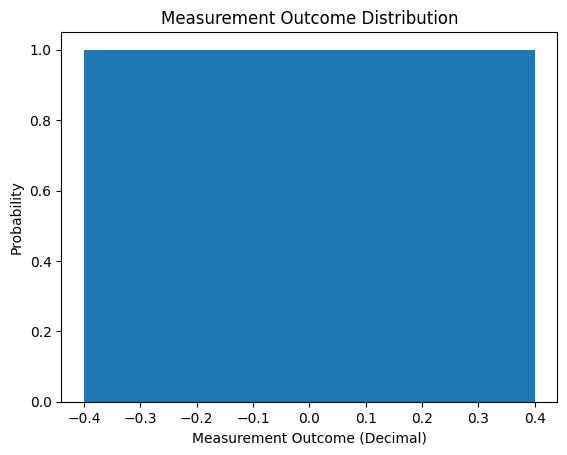

1
There was an issue with the period finder function.


In [93]:
from qiskit_aer import StatevectorSimulator


# Run the period finder
qc = period_finder(n, m, a, N)

qasm_simulator = Aer.get_backend("qasm_simulator")

# Transpile the circuit for the QasmSimulator
transpiled_qc = transpile(qc, qasm_simulator)

# Run the circuit with a high number of shots
job = qasm_simulator.run(transpiled_qc, shots=10000)
result = job.result()
counts = result.get_counts(qc)

print("Counts:\n", counts)

# Simulate the circuit to get the outputqc = period_finder(n, m, a, N)

# Simulate the circuit to get the output

simulator = Aer.get_backend("qasm_simulator")
qct = transpile(qc, simulator)
result = simulator.run(qct, shots=1000).result()

# Extract the measured state
counts = result.get_counts()
def extract_period(counts, n):
    measurements = list(map(int, counts.keys()))
    probabilities = list(map(lambda x: counts[x] / sum(counts.values()), counts.keys()))

    max_prob = 0
    period = 0

    for k in range(1, 2**n):
        prob_k = 0
        for i, meas in enumerate(measurements):
            if (meas * k) % (2**n) == 0:
                prob_k += probabilities[i]
        if prob_k > max_prob:
            max_prob = prob_k
            period = k

    return period

# Extract the measured state and calculate the period using the maximum likelihood method
counts = result.get_counts()
import matplotlib.pyplot as plt


def plot_measurement_outcomes(counts):
    measurements = list(map(int, counts.keys()))
    probabilities = list(map(lambda x: counts[x] / sum(counts.values()), counts.keys()))

    print("Measurements:", measurements)
    print("Probabilities:", probabilities)

    plt.bar(measurements, probabilities, width=0.8)

    plt.xlabel("Measurement Outcome (Decimal)")
    plt.ylabel("Probability")
    plt.title("Measurement Outcome Distribution")
    plt.show()

# Plot the measurement outcomes
plot_measurement_outcomes(counts)

period = extract_period(counts, n)

measured_state = max(counts, key=counts.get)

# Validate the output
expected_period = 4  # The expected period for a=2, N=15 is 4
print(period)
if period == expected_period:
    print("Period finder function is working correctly.")
else:
    print("There was an issue with the period finder function.")


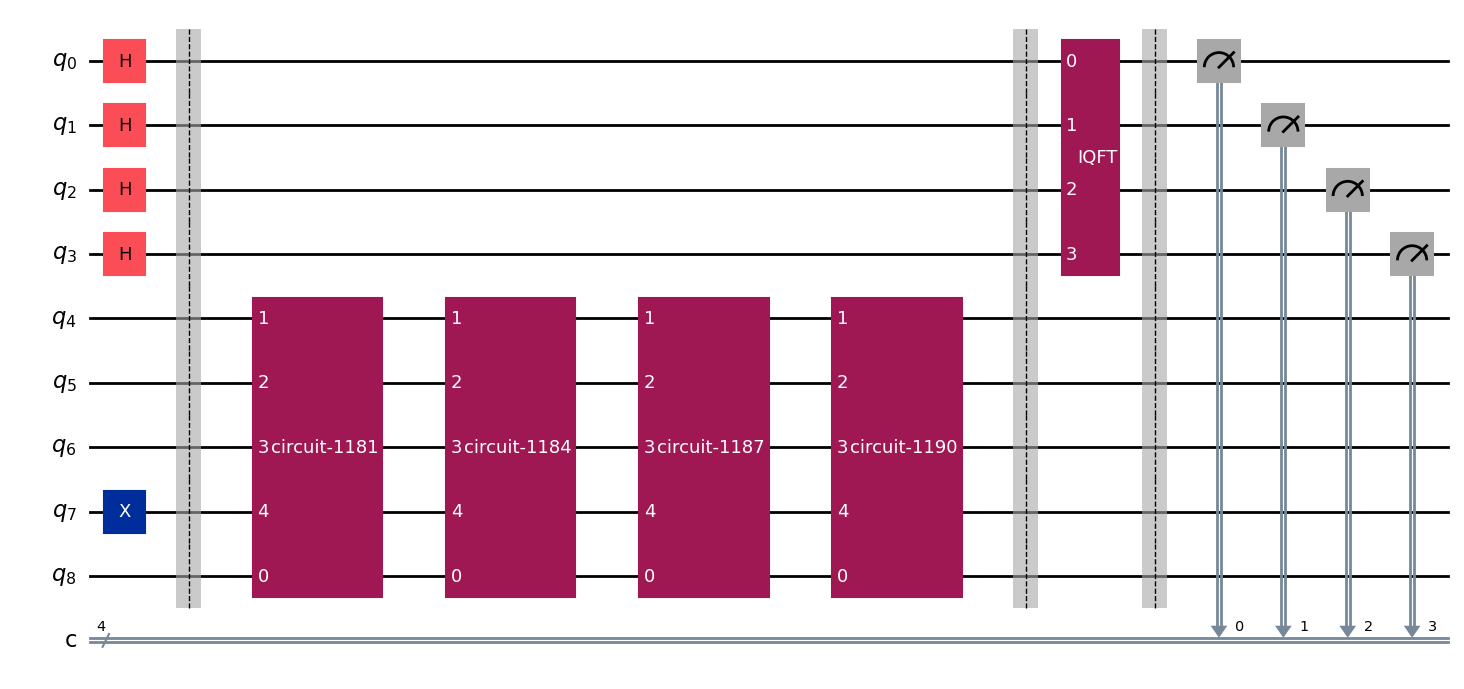

In [80]:
qc.draw(output="mpl")

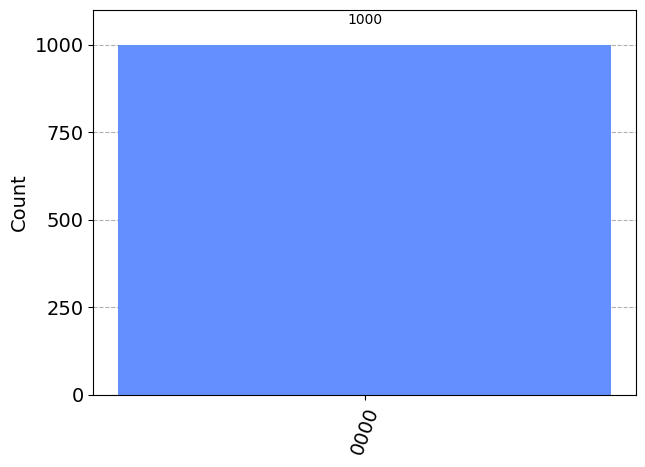

In [68]:
backend = Aer.get_backend("qasm_simulator")
qct = transpile(qc, backend)
counts = backend.run(qct, shots=1000).result().get_counts()

plot_histogram(counts)

In [69]:
counts_dec = sorted([int(measured_value[::-1], 2)
                     for measured_value in counts])

print("Measured periods:", end='\t')
for measured_value in counts_dec:
    print(measured_value, end='\t')

Measured periods:	0	

In [70]:
from math import gcd


factors = set()

for x in counts_dec:
    guesses = [gcd(int((a ** (measured_value/2))) + 1, N),
               gcd(int((a ** (measured_value/2))) - 1, N)]
    for guess in guesses:
        # ignore trivial factors
        if guess != 1 and guess != N and N % guess == 0:
            factors.add(guess)

if len(factors):
    P = factors.pop()
    Q = factors.pop() if len(factors) else N // P
    print(f"P = {P}\nQ = {Q}\n\n",
          f"{P} x {Q} = {N}, {P * Q == N}")
else:
    print("Shor's Algorithm Failed. Choose a different 'a'.")

Shor's Algorithm Failed. Choose a different 'a'.
